In [1]:
%matplotlib notebook

In [2]:
# wild_segmentation_unified.py is using an identical parameter setting, maybe generate worse result.
# NOTE: FOR 110, 114, 116, 118, 121, peaksIndex = peak_detection(proximity, min_prominence=3)

import os
import sys
import logging
import numpy as np
import pandas as pd
from datetime import date, time, datetime
sys.path.append('..')
from beyourself.core.algorithm import interval_intersect_interval
sys.path.append('../mining')
from periodic import periodic_subsequence, get_periodic_stat, peak_detection
from utils import create_folder, list_files_in_directory, df_to_datetime_tz_aware, datetime_str_to_unixtime, df_to_datetime_tz_aware,unixtime_to_datetime

from settings import settings
sys.path.append('../data_collect/necklace')
from read_data import read_data
from scipy.signal import boxcar, gaussian
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
from scipy.stats import skew, kurtosis
from numpy import mean, std, median, sqrt, hstack
from matplotlib import pyplot as plt
from matplotlib import interactive
from matplotlib.widgets import Cursor
import matplotlib
logger = logging.getLogger(__name__)



..\beyourself\settings.py:27: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [3]:
def smoothboxcar(data, selected_columns, winsize):
    """Boxcar smoothing of data

    Parameters
    ----------
    data:                   dataframe
    selected_columns:       list of keys, stating which columns will be smoothed
    winsize:                number of samples of rectangle window

    Return
    ------
    smoothed:               dataFrame

    """

    logger.info("Boxcar smoothing with winsize %d", winsize)

    smoothed = data.copy(deep=True)

    for col_header in selected_columns:
        column = smoothed[col_header].values

        # padding data
        # when winsize is even, int(winsize/2) is bigger than int((winsize-1)/2) by 1
        # when winsize is odd, int(winsize/2) is the same as int((winsize-1)/2)
        pad_head = [column[0]] * int((winsize - 1) / 2)
        pad_tail = [column[-1]] * int(winsize / 2)
        signal = np.r_[pad_head, column, pad_tail]

        window = boxcar(winsize)

        smoothed[col_header] = np.convolve(
            window / window.sum(), signal, mode='valid')

    return smoothed

In [4]:
# ==================================================================================
ROOT_DIR = settings['ROOT_DIR']
# subj = settings['subj']
#subj = str(sys.argv[1])
subj = 'Jaya'
#startDate = settings['START_DATE']
#calendarDayAmendHours = settings['CALENDAR_DAY_AMEND_HOURS']

ANNO_FOLDER = os.path.join(ROOT_DIR, 'ANNOTATION', subj, 'CHEWING')
DATA_FOLDER = os.path.join(ROOT_DIR, 'CLEAN', subj, 'NECKLACE')
TEMP_FOLDER = os.path.join(ROOT_DIR, 'pallas/wild', subj)
# ==================================================================================
create_folder(TEMP_FOLDER)

segFile = 'segments_' + subj + '.csv'
# segFile = 'segments_' + subj + '_unsampled.csv'

inclusion = pd.read_csv(os.path.join(ANNO_FOLDER, 'inclusion.csv'))
dfChewing = pd.read_csv(os.path.join(ANNO_FOLDER, 'chewing.csv'))
dfChewing = df_to_datetime_tz_aware(dfChewing, ['start', 'end'])
bites = inclusion['bites']

In [5]:

# intervalChewing = list(zip(dfChewing['start'].tolist(), dfChewing['end'].tolist()))
# # # checking that dfChewing is monotonic, no overlapping between chewing segments
# # # avoid human error in labeling
# # for i in range(1, dfChewing.shape[0]):
# #     diff = dfChewing['start'].iloc[i] - dfChewing['end'].iloc[i - 1]

# #     if not diff >= pd.Timedelta(0):
# #         bad = "Double check data!!! {}||{}||{}||{}".format(i, diff, dfChewing['start'].iloc[i],
# #                                                             dfChewing['end'].iloc[i - 1])
# #         raise ValueError(bad)

# segmentationConcatList = []



# files = list_files_in_directory(DATA_FOLDER)

# for file in files:
    
#     dfSensor = pd.read_csv(os.path.join(DATA_FOLDER,file))
#     dfSensor = smoothboxcar(dfSensor, ['proximity'], 7)
#     timeArr = dfSensor['Time'].values
#     proxArr = dfSensor['proximity'].values
#     # find_nonmonotonic(timeArr)
#     # be careful to pick prominence (check data is normalized or not)
#     peaksIndex = peak_detection(proxArr, min_prominence=3)
#     peaksTime = timeArr[peaksIndex]
#     subsequences = periodic_subsequence(peaksIndex, peaksTime, min_length=4, max_length=100,
#                                         eps=0.1, alpha=0.45, low=400, high=1200)
#     print('# subsequences: ', str(len(subsequences)))
#     if len(subsequences) == 0:
#         continue

#     segments = []
#     for index in subsequences:
#         seq = timeArr[index]
#         segments.append(get_periodic_stat(seq))

#     dfSubSegment = pd.DataFrame(segments, columns=['start', 'end', 'eps', 'pmin', 'pmax', 'length'])
#     segmentationConcatList.append(dfSubSegment)

# assert len(segmentationConcatList) != 0, "First check if you have the data files in directory " + DATA_FOLDER
# dfSegments = pd.concat(segmentationConcatList)
# dfSegments = dfSegments.drop_duplicates().reset_index(drop=True)

# intervalSegments = list(zip(dfSegments['start'].tolist(), dfSegments['end'].tolist()))

# # calculating ground truth
# intersect = interval_intersect_interval(groundtruth=intervalChewing,
#                                         prediction=intervalSegments)
# print("Recall: {}".format(intersect['recall']))
# dfSegments['chewing_gt'] = intersect['prediction_gt']

# # calculate date of experiment

# # dfSegments = dfSegments.drop_duplicates(keep=False).reset_index(drop=True)
# dfSegments.to_csv(os.path.join(TEMP_FOLDER, segFile), index=None)



# Generating all peaks for all position

In [6]:
inclusion_list = ['right','center','left','up','loose']

intervalChewing = list(zip(dfChewing['start'].tolist(), dfChewing['end'].tolist()))

segmentationConcatList = []
peakList = []
files = list_files_in_directory(DATA_FOLDER)

# if subj == 'Jaya':
#     chew_counts = jaya_chews
#     print('Result for Jaya.')
# elif subj == 'Chris':
#     chew_counts = chris_chews
#     print('Result for Chris')

    
for i in range(inclusion.shape[0]):
    start = datetime_str_to_unixtime(inclusion['start'].iloc[i])
    end = datetime_str_to_unixtime(inclusion['end'].iloc[i])
    
    dfSensor = read_data(DATA_FOLDER, start, end)
    dfSensor = smoothboxcar(dfSensor, ['proximity'], 2)
    
    timeArr = dfSensor['Time'].values
    proxArr = dfSensor['proximity'].values
    # find_nonmonotonic(timeArr)
    # be careful to pick prominence (check data is normalized or not)
    peaksIndex = peak_detection(proxArr, min_prominence=3)
    peaksTime = timeArr[peaksIndex]
    
    peakList.append(peaksTime)
    
    subsequences = periodic_subsequence(peaksIndex, peaksTime, min_length=4, max_length=100,
                                        eps=0.1, alpha=0.45, low=400, high=1200)
    print('# subsequences: ', str(len(subsequences)))
    
    print('=================================================================')
    print('The peak counts for {} is {}'.format(inclusion['label'][i],len(peaksIndex)))
    print('The chew counts for {} is {}'.format(inclusion['label'][i],bites[i]))
    print('=================================================================')
    
    if len(subsequences) == 0:
        continue

    segments = []
    for index in subsequences:
        seq = timeArr[index]
        segments.append(get_periodic_stat(seq))

    dfSubSegment = pd.DataFrame(segments, columns=['start', 'end', 'eps', 'pmin', 'pmax', 'length'])
    segmentationConcatList.append(dfSubSegment)
    
assert len(segmentationConcatList) != 0, "First check if you have the data files in directory " + DATA_FOLDER
dfSegments = pd.concat(segmentationConcatList)
dfSegments = dfSegments.drop_duplicates().reset_index(drop=True)

intervalSegments = list(zip(dfSegments['start'].tolist(), dfSegments['end'].tolist()))

# calculating ground truth
intersect = interval_intersect_interval(groundtruth=intervalChewing,
                                        prediction=intervalSegments)
print("Recall: {}".format(intersect['recall']))
dfSegments['chewing_gt'] = intersect['prediction_gt']

# calculate date of experiment

# dfSegments = dfSegments.drop_duplicates(keep=False).reset_index(drop=True)
dfSegments.to_csv(os.path.join(TEMP_FOLDER, segFile), index=None)


INFO:__main__:Boxcar smoothing with winsize 2
INFO:periodic:pmin 400.00 and pmax 638.00
INFO:periodic:pmin 440.00 and pmax 701.80
INFO:periodic:pmin 484.00 and pmax 771.98
INFO:periodic:pmin 532.40 and pmax 849.18
INFO:periodic:pmin 585.64 and pmax 934.10
INFO:periodic:pmin 644.20 and pmax 1027.51
INFO:periodic:pmin 708.62 and pmax 1130.26
# subsequences:  5
The peak counts for Right1 is 25
The chew counts for Right1 is 0
INFO:__main__:Boxcar smoothing with winsize 2
INFO:periodic:pmin 400.00 and pmax 638.00
INFO:periodic:pmin 440.00 and pmax 701.80
INFO:periodic:pmin 484.00 and pmax 771.98
INFO:periodic:pmin 532.40 and pmax 849.18
INFO:periodic:pmin 585.64 and pmax 934.10
INFO:periodic:pmin 644.20 and pmax 1027.51
INFO:periodic:pmin 708.62 and pmax 1130.26
# subsequences:  3
The peak counts for Right2 is 20
The chew counts for Right2 is 23
INFO:__main__:Boxcar smoothing with winsize 2
INFO:periodic:pmin 400.00 and pmax 638.00
INFO:periodic:pmin 440.00 and pmax 701.80
INFO:periodic:pmi

INFO:__main__:Boxcar smoothing with winsize 2
INFO:periodic:pmin 400.00 and pmax 638.00
INFO:periodic:pmin 440.00 and pmax 701.80
INFO:periodic:pmin 484.00 and pmax 771.98
INFO:periodic:pmin 532.40 and pmax 849.18
INFO:periodic:pmin 585.64 and pmax 934.10
INFO:periodic:pmin 644.20 and pmax 1027.51
INFO:periodic:pmin 708.62 and pmax 1130.26
# subsequences:  11
The peak counts for Up3 is 35
The chew counts for Up3 is 25
INFO:__main__:Boxcar smoothing with winsize 2
INFO:periodic:pmin 400.00 and pmax 638.00
INFO:periodic:pmin 440.00 and pmax 701.80
INFO:periodic:pmin 484.00 and pmax 771.98
INFO:periodic:pmin 532.40 and pmax 849.18
INFO:periodic:pmin 585.64 and pmax 934.10
INFO:periodic:pmin 644.20 and pmax 1027.51
INFO:periodic:pmin 708.62 and pmax 1130.26
# subsequences:  15
The peak counts for Up4 is 39
The chew counts for Up4 is 27
INFO:__main__:Boxcar smoothing with winsize 2
INFO:periodic:pmin 400.00 and pmax 638.00
INFO:periodic:pmin 440.00 and pmax 701.80
INFO:periodic:pmin 484.00 

# This part is for plotting and graph generating

In [40]:
#This num is the line number of the line of mouth-fold you want to visualize.

num = 14

#s = '2020-02-10 14:29:49.150000-06:00' #for num = 4

#e = '2017-08-24 17:47:10.000'

s = inclusion['start'].iloc[num]
e = inclusion['end'].iloc[num]

start = datetime_str_to_unixtime(s)
end = datetime_str_to_unixtime(e)
start_date = unixtime_to_datetime(start)
end_date = unixtime_to_datetime(end)

dfSensor_wrist = read_data(DATA_FOLDER,start,end)
#print(start)
dfSensor_wrist = dfSensor_wrist.reset_index(drop=True)
#dfSensor_wrist = extract_gravity(dfSensor_wrist)
#dfSensor_wrist = smoothboxcar(dfSensor_wrist, ['accX_linear','accY_linear','accZ_linear'], 1)
dfSensor_wrist = smoothboxcar(dfSensor_wrist, ['proximity'], 1)
#label = pd.read_csv(LABEL)
#label_list = df_to_datetime_tz_aware(label,['start','end'])

#chewing = pd.read_csv(CHEWING)
#chewing_list = df_to_datetime_tz_aware(chewing,['start','end'])
#print(chewing)
new = df_to_datetime_tz_aware(dfSensor_wrist,['Time'])




INFO:__main__:Boxcar smoothing with winsize 1


In [41]:
#====================================================
# Read all the detected peaks in the interval

peak_time = peakList[num]

#====================================================
# Save the picked data into csv file.

filename = 'Segment_' + inclusion['label'].iloc[num] + '.csv'
peakname = 'peaklist' + inclusion['label'].iloc[num] + '.csv'
dfSensor_wrist.to_csv(os.path.join(ROOT_DIR, filename), index=None)
dfPeak = pd.DataFrame(peak_time,columns = ['peak_time'])
dfPeak.to_csv(os.path.join(ROOT_DIR, peakname), index=None)

<IPython.core.display.Javascript object>


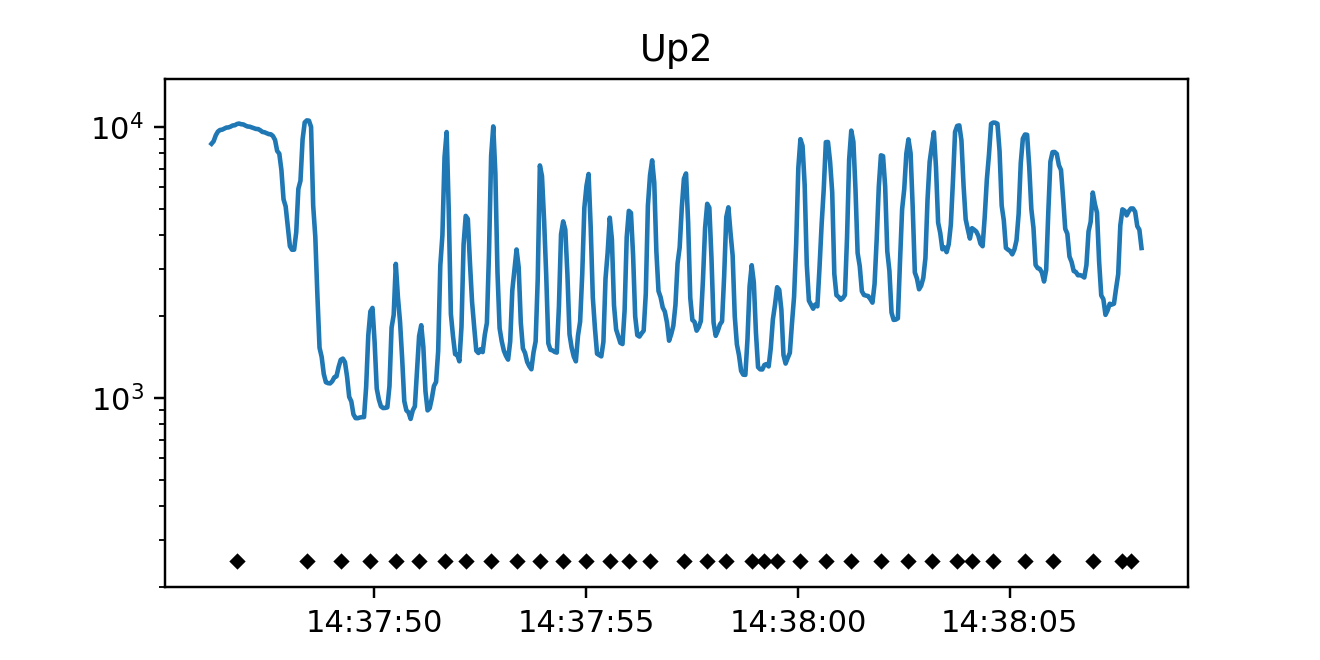

In [42]:
fig = plt.figure(num=None, figsize=(6, 3), dpi=100, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1,1,1)
plt.title(inclusion['label'].iloc[num])

plt.plot(new['Time'],dfSensor_wrist['proximity'])
plt.yscale("log")
plt.ylim(200,15000)
#start_time = datetime_str_to_unixtime('8/26/2017  6:00:00 PM')
# for i in range(len(label_list)):
#     if (label_list['start'].iloc[i] > start_date) and (label_list['end'].iloc[i] < end_date):
#         plt.axvspan(label_list['start'].iloc[i],label_list['end'].iloc[i] , color='red', alpha=0.3)
#         print('This is {}'.format(label_list['start'].iloc[i]))

# for i in range(len(chewing_list)):
#     if (chewing_list['start'].iloc[i] > start_date) and (chewing_list['end'].iloc[i] < end_date):
#         plt.axvspan(chewing_list['start'].iloc[i],chewing_list['end'].iloc[i] , color='blue', alpha=0.1)

for i in range(len(peak_time)):
    #plt.axvline(unixtime_to_datetime(peak_time[i]), color='blue', alpha=0.1)
    plt.plot(unixtime_to_datetime(peak_time[i]), 250 ,marker = 'D',markersize = 3, color = "black")
    
#plt.axvspan((datetime_str_to_unixtime('8/26/2017  6:04:30 PM') - start)/50,(datetime_str_to_unixtime('8/26/2017  6:04:42 PM') - start)/50 , color='red', alpha=0.2)  
cursor = Cursor(ax,useblit=True,color='red',linewidth=2)

plt.show()

In [43]:
print(inclusion['start'].iloc[num])
print(inclusion['end'].iloc[num])
print(inclusion['label'].iloc[num])

2020-02-10 14:37:46.150000-06:00
2020-02-10 14:38:08.150000-06:00
Up2
